In [1]:
!pip install -q catboost
!pip install -q pytorch-tabnet

     |████████████████████████████████| 66.3MB 69kB/s 


In [2]:
import os
os.chdir("/content/drive/MyDrive/Carte de vulnérabilité du COVID-19 en Afrique du Sud by Nimba Hub 3,000,000 GNF/")

In [3]:
## Reading libraries
import numpy as np
import pandas as pd

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import matplotlib.pyplot as plt # Matlab-style plotting
%matplotlib inline

import torch
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures,\
                                   PowerTransformer, KBinsDiscretizer, Normalizer, QuantileTransformer, FunctionTransformer)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,cross_val_score,KFold,RandomizedSearchCV

import pickle

from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [4]:
train = pd.read_csv('Data/Train_maskedv2.csv')
test = pd.read_csv('Data/Test_maskedv2.csv')
v_definition = pd.read_csv('Data/variable_descriptions_v2.csv')
submission = pd.read_csv('Data/samplesubmissionv2.csv')

In [5]:
## defining the metric
def metric(x,y):
  print("x",x)
  print("y",y)
  return np.sqrt(mean_squared_error(x,y))

In [6]:
class RMSE(Metric):
    def __init__(self):
        self._name = "rmse"
        self._maximize = True

    def __call__(self, y_true, y_score):
        rmse = mean_squared_error(y_true, y_score)
        return rmse

In [7]:
### Applying Kmeans to almost all features and generating a 'cluster' feature.
to_drop=['dw_11', 'dw_12','lan_13']
train_copy=train.copy()
columns=train_copy.drop(["ward","target_pct_vunerable"]+to_drop,1).columns
train_copy=train_copy[columns]
km=KMeans(7,random_state=42)
km=km.fit(train_copy[columns])
train["cluster"]=km.predict(train[columns])
test["cluster"]=km.predict(test[columns])

In [8]:
## Dropping wards in the training data that have more than 17500 households + 1 outlier.
train = train[train['total_households']<=17500]
train = train[train.index!=1094]

In [9]:
## Binned feature on total_households
train['total_householdslessthan5000'] = train['total_households'].apply(lambda x:1 if 2500<x<=5000  else 0)
test['total_householdslessthan5000'] = test['total_households'].apply(lambda x:1 if 2500<x<=5000  else 0)

###### A bunch of feature interactions

In [10]:
train['Individualsperhouse'] = train['total_individuals'] / train['total_households']
test['Individualsperhouse'] = test['total_individuals'] / test['total_households']

In [11]:
train['Luxury_01'] = train['car_01']+train['stv_00']+train['psa_01']
train['Luxury_00'] = train['car_00'] +train['stv_01']+train['psa_00']

In [12]:
test['Luxury_01'] = test['car_01']+test['stv_00']+test['psa_01']
test['Luxury_00'] = test['car_00'] +test['stv_01']+test['psa_00']

In [13]:
train['NoSchoolAttendace'] = train['psa_01'] + train['psa_02']+ train['psa_03']
test['NoSchoolAttendace'] = test['psa_01'] + test['psa_02']+ test['psa_03']

In [14]:
train['InformalDwellings'] = train['dw_02'] + train['dw_07'] + train['dw_06']
test['InformalDwellings'] = test['dw_02'] + test['dw_07'] + test['dw_06']

In [15]:
train['TraditionalVSInformalDwellings'] = np.absolute(train['dw_01'] - train['dw_08'])
test['TraditionalVSInformalDwellings'] = np.absolute(test['dw_01'] - test['dw_08'])

In [16]:
train['total_households']/=train['total_households'].max()
train['total_individuals']/=train['total_individuals'].max()

test['total_households']/=test['total_households'].max()
test['total_individuals']/=test['total_individuals'].max()

In [17]:
train['SAOldPeopleSesothoVSSetswana'] = np.absolute(train['lan_06'] - train['lan_07'])

test['SAOldPeopleSesothoVSSetswana'] = np.absolute(test['lan_06'] - test['lan_07'])

###### Target encoding + PCA 

In [18]:
target_mean = train.groupby(['cluster']).mean()[['target_pct_vunerable']]
for i in list(target_mean.columns):
  target_mean.rename({i:i+"_mean"},axis=1,inplace=True)
train = train.merge(target_mean,how="left",on='cluster')
test = test.merge(target_mean,how="left",on='cluster')


In [19]:
pca = PCA(random_state=42,n_components=1)
pg_features =  train.filter(regex='lan_.*')
train_pca = pca.fit_transform(pg_features)
train['pca_lan_0'] = train_pca[:,0]

In [20]:
pg_features =  test.filter(regex='lan_.*')
test_pca = pca.transform(pg_features)
test['pca_lan_0'] = test_pca[:,0]

###### Training.

In [21]:
train = train.drop(['psa_00','psa_02','psa_03','psa_04','psa_01','lgt_00','stv_01','car_01','lln_01','ward','dw_12','dw_13','lan_13'], axis=1)
test = test.drop(['psa_00','psa_02','psa_03','psa_04','psa_01','lgt_00','stv_01','car_01','lln_01','ward','dw_12','dw_13','lan_13'], axis=1)
train_sp, val_sp = train_test_split(train, train_size=0.8, random_state=2021)

In [ ]:
train.info()

In [ ]:
pwd

'/content/drive/My Drive/Carte de vulnérabilité du COVID-19 en Afrique du Sud by Nimba Hub 3,000,000 GNF'

In [ ]:
!ls

Data  google-research  Notebooks  Submissions  voting_alpha.csv.pkl


In [22]:
target = train['target_pct_vunerable']

In [23]:
train = train.drop(['target_pct_vunerable'], axis=1)

In [24]:
tabnet = TabNetRegressor(seed=2020)

Device used : cuda


In [ ]:
tabnet.get_params()

{'cat_dims': [],
 'cat_emb_dim': 1,
 'cat_idxs': [],
 'clip_value': 1,
 'device_name': 'auto',
 'epsilon': 1e-15,
 'gamma': 1.3,
 'input_dim': None,
 'lambda_sparse': 0.001,
 'mask_type': 'sparsemax',
 'momentum': 0.02,
 'n_a': 8,
 'n_d': 8,
 'n_independent': 2,
 'n_shared': 2,
 'n_steps': 3,
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02},
 'output_dim': None,
 'scheduler_fn': None,
 'scheduler_params': {},
 'seed': 2020,
 'verbose': 1}

In [ ]:
train[["cluster", "total_householdslessthan5000"]]

,cluster,total_householdslessthan5000
0,4,0
1,5,0
2,6,1
3,6,0
4,6,0
...,...,...
3149,1,0
3150,5,0
3151,5,0
3152,4,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3154 entries, 0 to 3153
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   total_households                3154 non-null   float64
 1   total_individuals               3154 non-null   float64
 2   dw_00                           3154 non-null   float64
 3   dw_01                           3154 non-null   float64
 4   dw_02                           3154 non-null   float64
 5   dw_03                           3154 non-null   float64
 6   dw_04                           3154 non-null   float64
 7   dw_05                           3154 non-null   float64
 8   dw_06                           3154 non-null   float64
 9   dw_07                           3154 non-null   float64
 10  dw_08                           3154 non-null   float64
 11  dw_09                           3154 non-null   float64
 12  dw_10                           31

In [ ]:
tabnet_params ={
                'clip_value': np.arange(0, 2, 0.1),
                'gamma': np.arange(1, 2, 0.1),
                'lambda_sparse': np.arange(0, 0.05, 0.001),
                'mask_type': ['sparsemax', 'entmax'],
                'momentum': np.arange(0.01, 0.4, 0.01),
                'n_independent': np.arange(1, 6),
                'n_shared': np.arange(1, 6),
                'n_steps': np.arange(3, 7),
             }

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
search = RandomizedSearchCV(tabnet, tabnet_params, cv=5, n_iter=20, verbose=0, scoring='neg_mean_squared_error')

In [ ]:
train.values.shape, target.values.reshape((-1,1)).reshape((-1,1)).shape

((3154, 47), (3154, 1))

In [ ]:
search.fit(train.values, 
           target.values.reshape((-1, 1))
           )

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=TabNetRegressor(cat_dims=[], cat_emb_dim=1, cat_idxs=[], clip_value=1, device_name='auto', epsilon=1e-15, gamma=1.3, input_dim=None, lambda_sparse=0.001, mask_type='sparsemax', momentum=0.02, n_a=8, n_d=8, n_independent=2, n_shared=2, n_steps=3, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.0...
       1761, 1766, 1771, 1776, 1781, 1786, 1791, 1796, 1801, 1806, 1811,
       1816, 1821, 1826, 1831, 1836, 1841, 1846, 1851, 1856, 1861, 1866,
       1871, 1876, 1881, 1886, 1891, 1896, 1901, 1906, 1911, 1916, 1921,
       1926, 1931, 1936, 1941, 1946, 1951, 1956, 1961, 1966, 1971, 1976,
       1981, 1986, 1991, 1996, 2001, 2006, 2011, 2016])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring='neg_root_mean_squared_error', verbose=0)

In [ ]:
search.best_params_

{'cat_idxs': [36, 37],
 'clip_value': 1.9000000000000001,
 'gamma': 1.9000000000000008,
 'lambda_sparse': 0.037,
 'mask_type': 'entmax',
 'momentum': 0.15000000000000002,
 'n_a': 8,
 'n_d': 11,
 'n_independent': 1,
 'n_shared': 2,
 'n_steps': 4,
 'seed': 316}

In [25]:
kf = KFold(n_splits=4,shuffle=False, random_state=316)
tab = TabNetRegressor(mask_type="sparsemax",clip_value=1.9, gamma=1.9,lambda_sparse=0.37,
                      momentum=0.15, n_a=8, n_d=11, n_independent=1, n_shared=2, n_steps=4, seed=316)
scores = []
pred_test = np.zeros((len(test), 1))
for (train_index,test_index) in kf.split(train,target):
  X_train,X_test = train.iloc[train_index].values,train.iloc[test_index].values
  y_train,y_test = target.iloc[train_index].values.reshape((-1, 1)),target.iloc[test_index].values.reshape((-1, 1))
  tab.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric=[RMSE], max_epochs=10000, patience=500)
  scores.append(metric(tab.predict(X_test),y_test))
  pred_test+=tab.predict(test.values)

Streaming output truncated to the last 5000 lines.
 [3.24242117e-01]
 [3.21823081e-01]
 [1.99105742e+01]
 [7.24635070e-02]
 [1.36049271e-01]
 [1.32314767e+01]
 [7.36166806e+00]
 [3.24362388e+01]
 [1.92180408e+01]
 [3.12926759e+01]
 [1.00619236e+01]
 [9.37976543e+00]
 [2.85165966e+01]
 [3.68037504e+00]
 [3.70564981e+00]
 [1.75212985e-01]
 [3.99015162e+01]
 [0.00000000e+00]
 [2.60993864e+01]
 [2.13047839e+00]
 [1.84137608e+01]
 [5.75303141e-01]
 [3.52954117e+01]
 [1.67942494e+00]
 [6.07709847e-01]
 [1.23925204e+01]
 [5.03102884e+00]
 [4.23476857e+01]
 [4.19231277e-01]
 [5.28137793e-01]
 [1.84950712e+01]
 [1.10424217e+00]
 [2.60977638e+00]
 [3.44901310e-01]
 [1.20980259e+01]
 [2.34753983e-01]
 [2.84465140e+00]
 [5.62055754e+00]
 [1.23143472e+00]
 [3.49042831e+00]
 [2.07550016e-01]
 [3.14886111e+01]
 [3.86563020e-01]
 [3.86793910e-02]
 [3.26119727e-01]
 [9.90151637e-01]
 [6.08617090e-02]
 [2.78391897e+01]
 [1.22449533e+01]
 [1.00366776e+00]
 [2.11555990e+00]
 [6.41813650e-02]
 [4.22301883e

In [26]:
np.mean(scores)

6.078556134033549

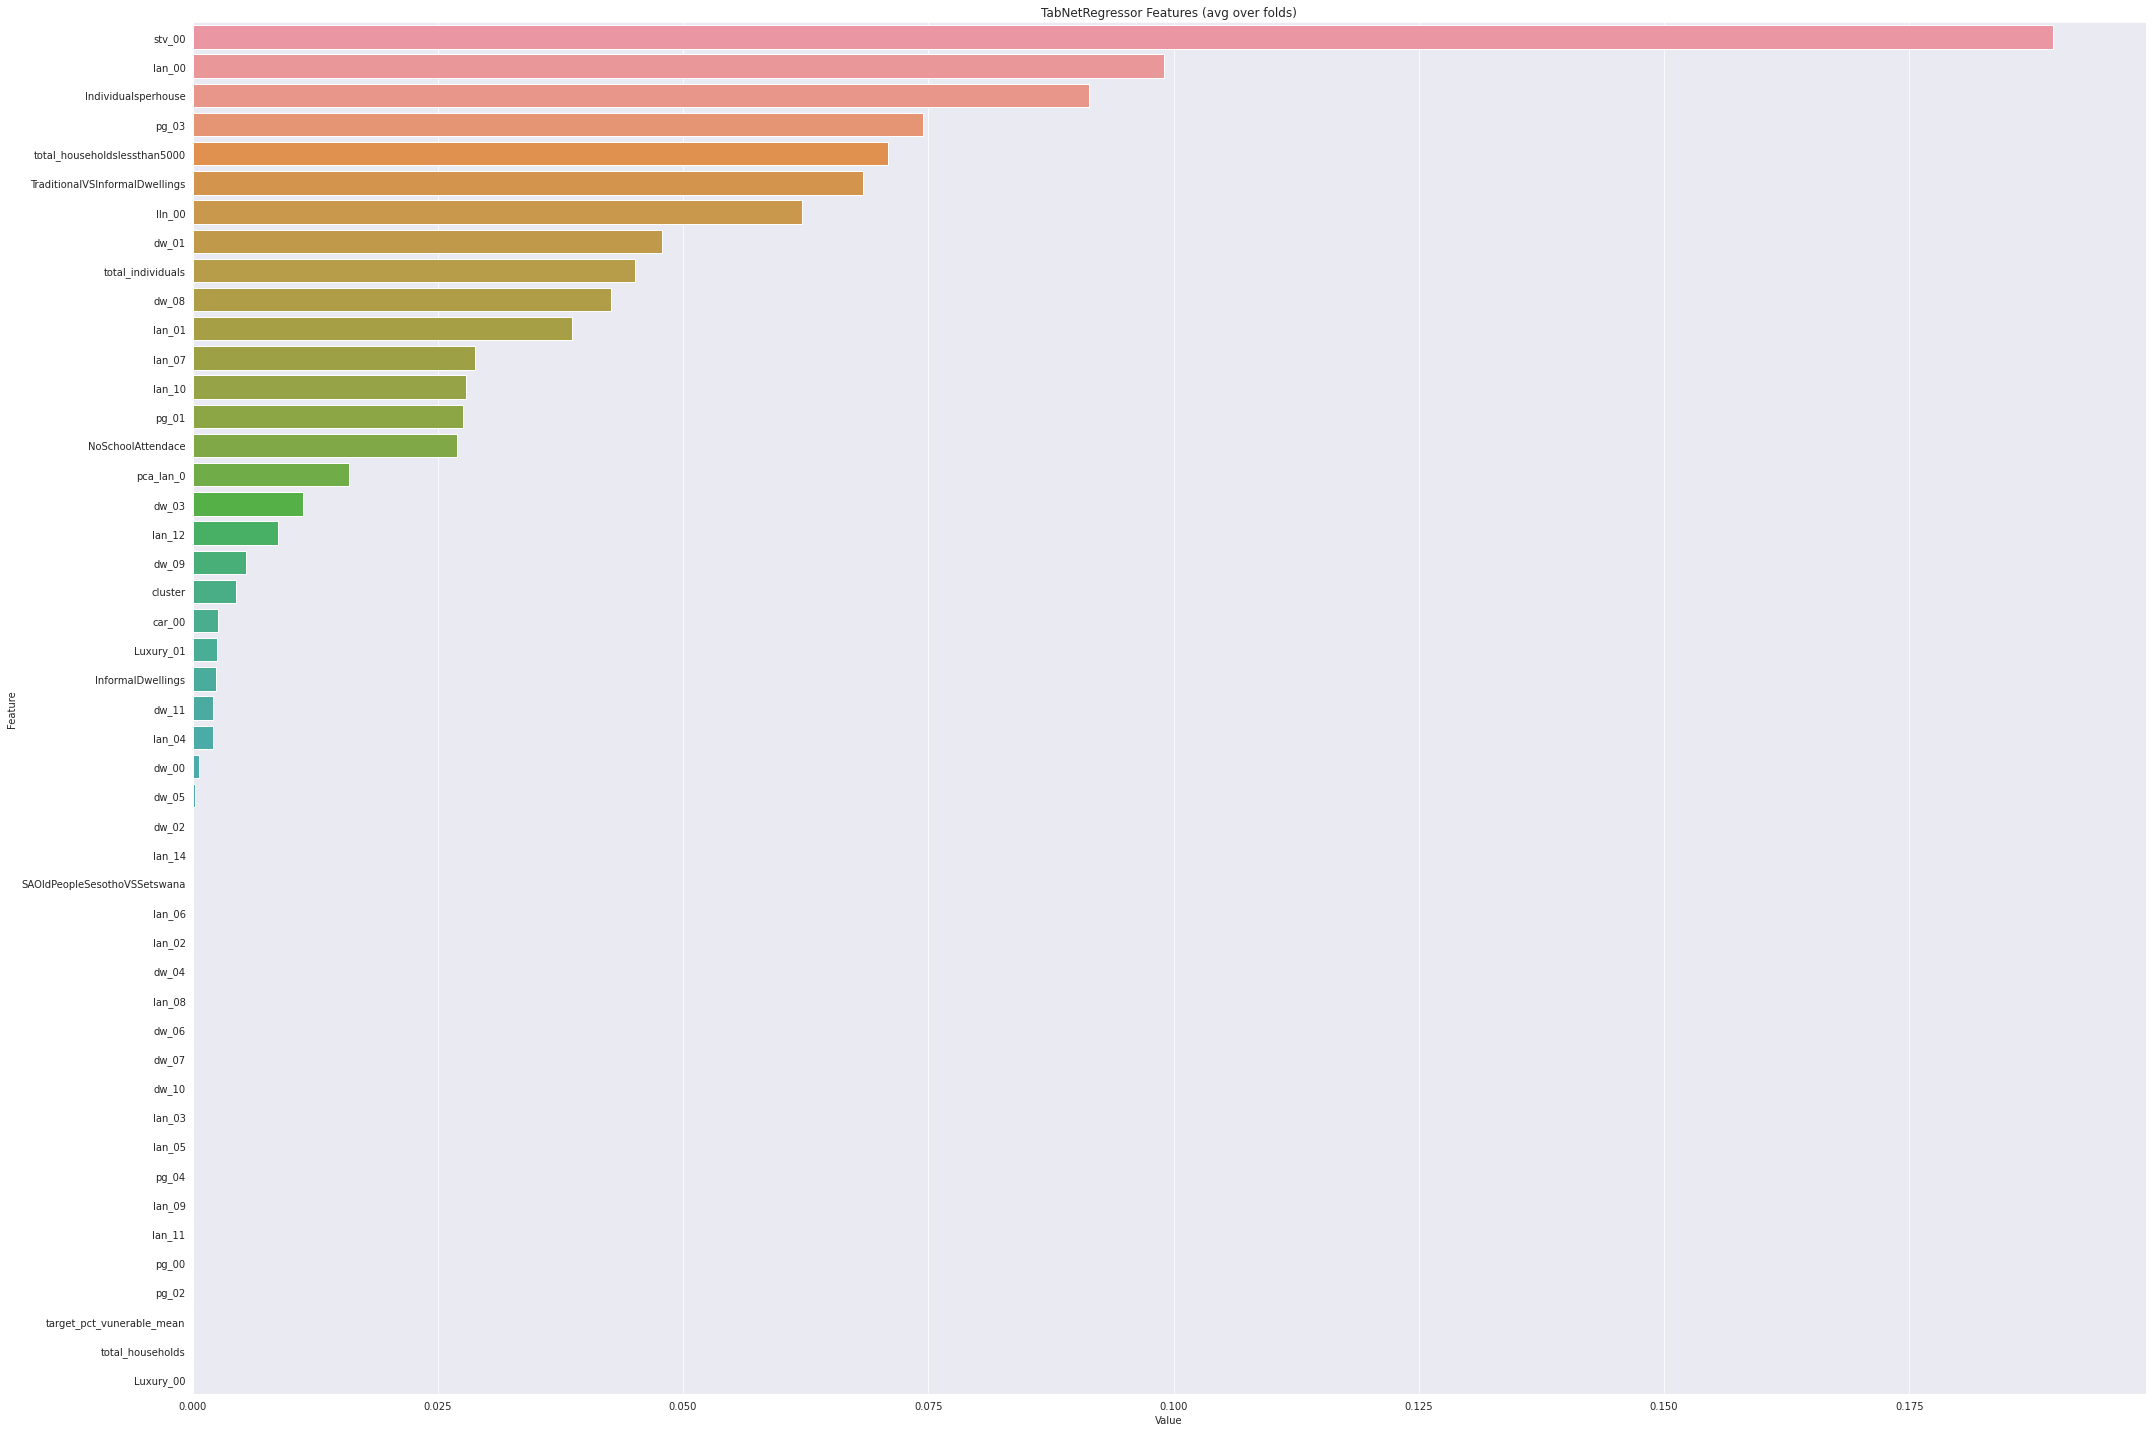

In [27]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(tab.feature_importances_,train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(30, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('TabNetRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()

In [28]:
submission['target_pct_vunerable'] = np.absolute(pred_test/4)
submission.to_csv('Submissions/tabnet_sparsemax_tuned.csv',index=False)

In [ ]:
# tab = TabNetRegressor(mask_type="entmax", cat_idxs=[36, 37], clip_value=1.9, gamma=1.9,lambda_sparse=0.37,
#                       momentum=0.15, n_a=8, n_d=11, n_independent=1, n_shared=2, n_steps=4, seed=316)
# tab.fit(train.values,target.values.reshape((-1, 1)),eval_set=[(X_test,y_test)],eval_metric=[RMSE], max_epochs=10000, patience=500)

# pred =tab.predict(test.values)

# submission['target_pct_vunerable'] = np.absolute(pred)
# submission.to_csv('Submissions/tabnet_entmax_tuned_no_cv.csv',index=False)

Device used : cuda
epoch 0  | loss: 235.59809| val_0_rmse: 14.45387|  0:00:00s
epoch 1  | loss: 198.96629| val_0_rmse: 14.22129|  0:00:00s
epoch 2  | loss: 144.60555| val_0_rmse: 13.8299 |  0:00:00s
epoch 3  | loss: 100.58363| val_0_rmse: 12.48856|  0:00:01s
epoch 4  | loss: 79.99727| val_0_rmse: 12.39844|  0:00:01s
epoch 5  | loss: 68.33682| val_0_rmse: 12.90473|  0:00:01s
epoch 6  | loss: 61.60449| val_0_rmse: 13.21706|  0:00:01s
epoch 7  | loss: 57.40645| val_0_rmse: 13.9375 |  0:00:02s
epoch 8  | loss: 54.11816| val_0_rmse: 13.66743|  0:00:02s
epoch 9  | loss: 54.33122| val_0_rmse: 13.98806|  0:00:02s
epoch 10 | loss: 51.01364| val_0_rmse: 14.09857|  0:00:02s
epoch 11 | loss: 49.83866| val_0_rmse: 13.69589|  0:00:03s
epoch 12 | loss: 48.40419| val_0_rmse: 13.57452|  0:00:03s
epoch 13 | loss: 46.84931| val_0_rmse: 13.72585|  0:00:03s
epoch 14 | loss: 47.63589| val_0_rmse: 13.78942|  0:00:03s
epoch 15 | loss: 46.2724 | val_0_rmse: 13.91962|  0:00:03s
epoch 16 | loss: 47.43999| val_0_